The following code is used to QC the pseudobulks created through pseudobulks_6k.py.

In [12]:
# import the code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from cortex_sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr, pearsonr
from collections import Counter

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

#module import to reload sc_preprocess
from importlib import reload 
sc_preprocess = reload(sc_preprocess)

Set up experiment parameters

In [13]:
# number of pseudobulks PER patient
n_train = 1000

### create the domains label 

# first for 10x data
Label_full_10x = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full_10x = to_categorical(Label_full_10x)

Label_perturb = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 0), np.full(n_train, 0)], axis=0)
label_perturb = to_categorical(Label_perturb)

label_full_10x

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Load Data

In [14]:
work_dir= '/beevol/home/ivicha/Greene_rotation_project/sc_bulk_ood_AI/evaluation_experiments/cortex'
res_path= f"{work_dir}/../../results/single_cell_data/diva_cortex"
data_path=f"{work_dir}/../../data/single_cell_data/augmented_cortex_data/"
bp_res_path = f"{work_dir}/../../results/single_cell_data/bp_cortex/"
cs_res_path = f"{work_dir}/../../results/single_cell_data/cibersort_cortex/"

def read_gene_file(res_path, exp_id):
    gene_file = os.path.join(res_path, f"train-{exp_id}-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train


exp_id = "cortex6k"
cortex6k_X, cortex6k_Y, cortex6k_gene_df = sc_preprocess.read_all_diva_files(data_path, range(10), exp_id)
cortex6k_X.columns = cortex6k_gene_df


Make TSNE of raw and trainign data

In [18]:
def make_tsne_fig(X_df, color_vec, ax, title):
    ## plot samples
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
        tsne_results = tsne.fit_transform(scale(np.log2(X_df.astype(float)+1.0), axis=1))

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    plot_df['class'] = color_vec

    n_colors = len(np.unique(color_vec))
    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="class",
        palette=sns.color_palette("hls", n_colors),
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


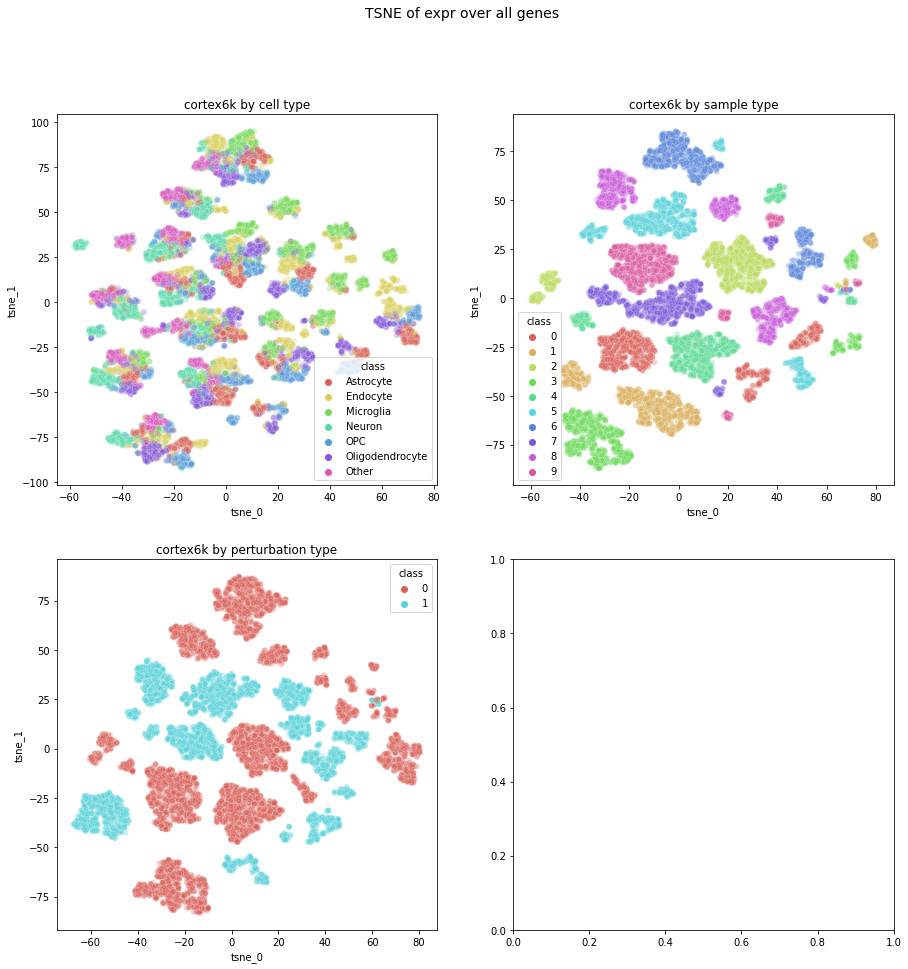

In [19]:

# plot over all genes
fig, axs = plt.subplots(2, 2, figsize=(15,15))
tmp_Y = cortex6k_Y
tmp_Y = tmp_Y.to_numpy()

tmp_Y = cortex6k_Y.columns[np.argmax(tmp_Y, axis=1)]
make_tsne_fig(cortex6k_X, tmp_Y, ax=axs[0,0], title="cortex6k by cell type")
make_tsne_fig(cortex6k_X, Label_full_10x, ax=axs[0,1], title="cortex6k by sample type")
make_tsne_fig(cortex6k_X, Label_perturb, ax=axs[1,0], title="cortex6k by perturbation type")


fig.suptitle("TSNE of expr over all genes", fontsize=14)

fig.show()